In [1]:
import os
import cv2
import numpy as np
from skimage import io
import itertools
import pickle
from pprint import pprint
import pandas as pd
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../../src/models")

from predict import CarCountingModel as Model
from evaluate_model import evaluate_model

/opt/conda/envs/py3.6/lib/python3.6/site-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


## Count cars on all test scenes

In [2]:
model_path = "../../models/logs/model_iter_85458"
insize = 96
count_ignore_width=8
car_max = 9
class_num = car_max + 1

mean_path = "../../data/cowc_processed/train_val/crop/mean.npy"
mean = np.load(mean_path)

model = Model(model_path, class_num, insize, mean)

In [3]:
eval_result, scene_info_list = evaluate_model(
    model,
    test_scene_list="../../data/cowc_processed/test/test_scenes.txt", 
    data_root="../../data/cowc/datasets/ground_truth_sets",
    count_ignore_width=count_ignore_width,
    car_max=car_max
)

with open("eval_result.pickle", 'wb') as handle:
    pickle.dump(eval_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("scene_info_list.pickle", 'wb') as handle:
    pickle.dump(scene_info_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading Utah_AGRC/12TVL180140 ... (1/7)


27889 / 27889


Loading Utah_AGRC/12TVL200180 ... (2/7)


27889 / 27889


Loading Utah_AGRC/12TVL240120 ... (3/7)


27889 / 27889


Loading Utah_AGRC/12TVK220980-CROP ... (4/7)


7225 / 7225


Loading Utah_AGRC/12TVL160640-CROP ... (5/7)


8281 / 8281


Loading Utah_AGRC/12TVL160660-CROP ... (6/7)


5476 / 5476


Loading Utah_AGRC/12TVL220360-CROP ... (7/7)


12769 / 12769


In [4]:
#with open("eval_result.pickle", 'rb') as handle:
#    eval_result = pickle.load(handle)

#with open("scene_info_list.pickle", 'rb') as handle:
#    scene_info_list = pickle.load(handle)

## Show evaluation result over all test scenes and at each scene

In [5]:
# Evaluation metrics over all test scenes
pprint(eval_result['metrics'])
pprint(eval_result['cars'])

{'accuracy': 0.9739051934115723,
 'accuracy_1': 0.9960568226336678,
 'accuracy_2': 0.9989098775315539,
 'mae': 0.032209712309867314,
 'proposal_accuracy': 0.9869525967057862,
 'rmse': 0.2308240361082472}
{'counted': 18557, 'labeled': 19507}


In [6]:
# Evaluation metrics at each test scene
for scene_info in scene_info_list:
    print(scene_info['scene'])
    pprint(scene_info['eval']['metrics'])
    pprint(scene_info['eval']['cars'])
    print()

Utah_AGRC/12TVL180140
{'accuracy': 0.9933665602925885,
 'accuracy_1': 0.9994621535372369,
 'accuracy_2': 0.9998924307074474,
 'mae': 0.00727885546272724,
 'proposal_accuracy': 0.9953745204202373,
 'rmse': 0.0937274002544822}
{'counted': 839, 'labeled': 806}

Utah_AGRC/12TVL200180
{'accuracy': 0.9905697586862203,
 'accuracy_1': 0.9980637527340529,
 'accuracy_2': 0.9995697228297895,
 'mae': 0.012047760765893364,
 'proposal_accuracy': 0.9939761196170533,
 'rmse': 0.13863277727892487}
{'counted': 779, 'labeled': 751}

Utah_AGRC/12TVL240120
{'accuracy': 0.9345261572663057,
 'accuracy_1': 0.992075728781957,
 'accuracy_2': 0.9987808813510703,
 'mae': 0.07490408404747391,
 'proposal_accuracy': 0.9699164545161175,
 'rmse': 0.31223970837086684}
{'counted': 12412, 'labeled': 13201}

Utah_AGRC/12TVK220980-CROP
{'accuracy': 0.9760553633217993,
 'accuracy_1': 0.9982006920415225,
 'accuracy_2': 0.9995847750865052,
 'mae': 0.02615916955017301,
 'proposal_accuracy': 0.9851903114186851,
 'rmse': 0.17725

In [7]:
# Ok, wrap these metrics into pandas DataFrame to show them in one table

def rename_keys(metrics, cars):
    
    renamed = {}
    renamed['Labeled cars'] = cars['labeled']
    
    renamed['MAE'] = metrics['mae']
    renamed['RMSE'] = metrics['rmse']
    renamed['Accuracy'] = metrics['accuracy']
    renamed['Accuracy ±1'] = metrics['accuracy_1']
    renamed['Accuracy ±2'] = metrics['accuracy_2']
    renamed['Proposal accuracy'] = metrics['proposal_accuracy']
    
    return renamed


metrics_dict = {}

for scene_info in scene_info_list:
    scene = scene_info['scene']
    metrics_dict[scene] = rename_keys(scene_info['eval']['metrics'], scene_info['eval']['cars'])

metrics_dict['All'] = rename_keys(eval_result['metrics'], eval_result['cars'])


metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df.sort_index(ascending=True)

metrics_df

,Labeled cars,MAE,RMSE,Accuracy,Accuracy ±1,Accuracy ±2,Proposal accuracy
All,19507,0.032210,0.230824,0.973905,0.996057,0.998910,0.986953
Utah_AGRC/12TVK220980-CROP,812,0.026159,0.177253,0.976055,0.998201,0.999585,0.985190
Utah_AGRC/12TVL160640-CROP,2783,0.087791,0.520907,0.951817,0.982852,0.991064,0.983577
Utah_AGRC/12TVL160660-CROP,608,0.025383,0.179786,0.977721,0.997261,0.999635,0.985026
Utah_AGRC/12TVL180140,806,0.007279,0.093727,0.993367,0.999462,0.999892,0.995375
Utah_AGRC/12TVL200180,751,0.012048,0.138633,0.990570,0.998064,0.999570,0.993976
Utah_AGRC/12TVL220360-CROP,546,0.007753,0.090681,0.992482,0.999765,1.000000,0.994440
Utah_AGRC/12TVL240120,13201,0.074904,0.312240,0.934526,0.992076,0.998781,0.969916


## Plot ground-truth vs predicted car number with RMS errors

In [8]:
# Use`mean` and `rms` values to plot

pprint(eval_result['stats'])

{0: {'accuracy': 0.9941574529453093,
     'accuracy_1': 0.999371371519432,
     'accuracy_2': 0.9998705764892948,
     'mae': 0.006656066264837481,
     'mean': 0.006656066264837481,
     'rmse': 0.09371397790614748},
 1: {'accuracy': 0.7997885835095138,
     'accuracy_1': 0.9968287526427061,
     'accuracy_2': 0.9985200845665962,
     'mae': 0.20486257928118393,
     'mean': 0.8906976744186047,
     'rmse': 0.4659664534377844},
 2: {'accuracy': 0.7455,
     'accuracy_1': 0.943,
     'accuracy_2': 0.999,
     'mae': 0.313,
     'mean': 1.807,
     'rmse': 0.6587867636800242},
 3: {'accuracy': 0.6654099905749293,
     'accuracy_1': 0.9236569274269557,
     'accuracy_2': 0.9764373232799246,
     'mae': 0.43732327992459946,
     'mean': 2.764373232799246,
     'rmse': 0.8407617389024443},
 4: {'accuracy': 0.6661931818181818,
     'accuracy_1': 0.9161931818181818,
     'accuracy_2': 0.9715909090909091,
     'mae': 0.4630681818181818,
     'mean': 3.8380681818181817,
     'rmse': 0.92318618

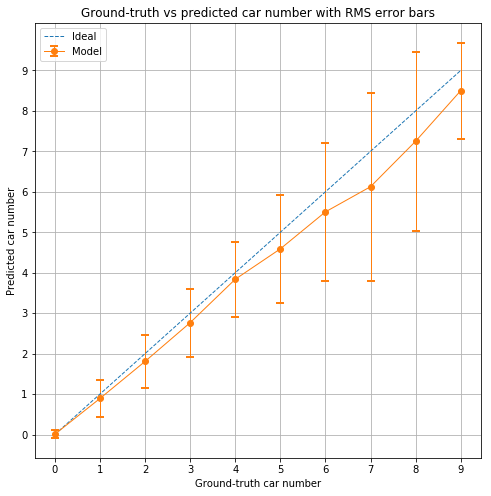

In [9]:
cars_gt = np.arange(car_max + 1)
means = np.empty(shape=[car_max + 1,])
errors = np.empty(shape=[car_max + 1,])

for (k, v) in eval_result['stats'].items():
    means[k] = v['mean']
    errors[k] = v['rmse']

# Plot
fig = plt.figure(figsize=(8, 8))
plt.plot(cars_gt, cars_gt, '--', lw=1, label='Ideal')
plt.errorbar(cars_gt, means, yerr=errors, lw=1, capsize=4, capthick=2, fmt='-o', label='Model')

plt.xticks(np.arange(car_max+1))
plt.yticks(np.arange(car_max+1))
plt.grid()

plt.title('Ground-truth vs predicted car number with RMS error bars')
plt.xlabel('Ground-truth car number')
plt.ylabel('Predicted car number')

plt.legend();

## Show confusion matrix over all test scenes

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(8, 7)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm_orig = cm.copy()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig = plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm_orig[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground-truth car number')
    plt.xlabel('Predicted car number')
    plt.tight_layout()

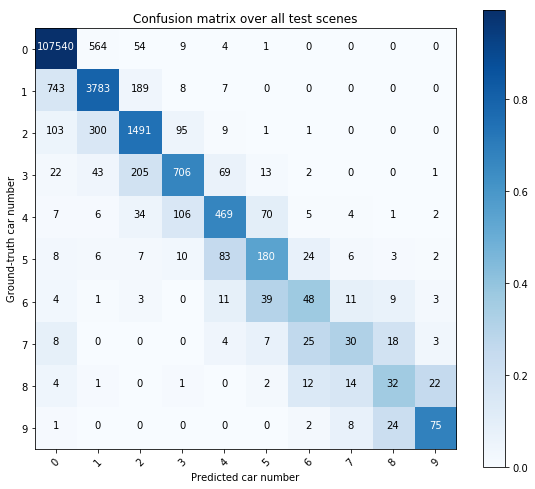

In [11]:
confusion = eval_result['confusion']

plot_confusion_matrix(confusion, np.arange(confusion.shape[0]), title='Confusion matrix over all test scenes')